In [1]:
# import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pencil as pc
from scipy.ndimage import gaussian_filter
from scipy.optimize import curve_fit
from scipy.integrate import trapezoid as trap
from astropy.convolution import convolve, Box1DKernel
import modes
from IPython.display import display, Latex

         pencil has moved to pencil_old.
To change your scripts accordingly:
import pencilnew as pc -> import pencil as pc
import pencil as pc -> import pencil_old as pc


In [2]:
plt.rcParams.update({'font.size': 12})
plt.rcParams['text.usetex'] = True

In [3]:
sim = pc.get_sim(quiet=True)
ts = pc.read.ts()

Read 40218 lines.


In [4]:
yaver = pc.read.aver(plane_list='y')

In [5]:
xyaver = pc.read.aver(plane_list=['xy'])

In [6]:
class Phase(modes.Modes):
    """
    To analyze different phases
    """

    def __init__(self, path, t1, t2, z_ref, norm, sim, ts, xyaver, yaver, ini=False, dyn=True):
        super().__init__(sim, ts, xyaver, yaver, ini=False, dyn=True)

        self.path = path
        self.t = self.yaver.t
        self.z_ref = z_ref
        self.norm = norm

        self.kf = super().get_kf()
        self.indx_t1 = np.argmin(np.abs(self.yaver.t-t1))
        self.indx_t2 = np.argmin(np.abs(self.yaver.t-t2))

        self.uz_real = self.yaver.y.uzmxz[self.indx_t1:self.indx_t2,:,self.z_ref]
        self.uz_fourier = super().FT(self.uz_real, self.norm)
        # self.uz_fourier = super().FT(self.uz_real, 'ortho')
        self.log_P = super().logP(self.uz_fourier, self.d)
        self.om_til = super().omega_tilde(self.indx_t1, self.indx_t2)
        self.k_til = super().k_tilde()
        self.upto_indx = super().upto(self.indx_t1, self.indx_t2)

    def indx_k(self, k_xtil:np.ndarray):
        indx = np.argmin(np.abs(self.k_til-k_xtil))
        return indx
    
    def Power(self, indx:int):
        P = np.exp(self.log_P[:self.upto_indx,indx])
        return P
    
    def Power_filtered(self, power:np.ndarray, sigma):
        P_filt = gaussian_filter(power[:self.upto_indx],sigma)
        return P_filt
    
    def f_freq(self, k_tilx, qq=False):
        freq = round(self.fmodes(k_tilx, qq),3)
        return freq
    
    def p_freq(self, k_tilx, num):
        if isinstance(num, int):
            freq = round(self.pmodes(k_tilx,num),3)
        if isinstance(num, list):
            freq=[]
            for i in range(len(num)):
                freq.append(self.pmodes(k_tilx,i))
        return freq
    
    def plot(self, ax, P:np.ndarray, **kwargs):
        ax.plot(self.om_til[:self.upto_indx], P, **kwargs)
        # ax.grid()
        # ax.set_ylim(0,)
        ax.legend()

    def xlim(self, x_data:np.ndarray):
        min = x_data[0]
        max = x_data[-1]
        return (min,max)
    
    def cs_du(self, k_tilx):
        csd = self.cs_d*k_tilx/(self.L0*self.omega0)
        csu = self.cs_u*k_tilx/(self.L0*self.omega0)
        return (csd, csu)

    def mode_fit_para(self, func, x_data, y_data, **kwargs):
        para, _ = curve_fit(func, x_data, y_data, **kwargs)
        return para
    
    def mode_fit_extend(self, func, x, para):
        y = func(x, *para)-x*para[4]-para[3]
        return y

    pass

In [7]:
path = './plots/'

In [8]:
# saturated.indx_t2

In [9]:
kinematic = Phase(path, 50, 2550, 212, 'ortho', sim, ts, xyaver, yaver, ini=False, dyn=True)
# kinematic = Phase(path, 100, 1500, 212, None, sim, ts, xyaver, yaver, ini=False, dyn=True)
# saturated = Phase(path, 2550, 3950, 212, 'ortho', sim, ts, xyaver, yaver, ini=False, dyn=True)
# saturated = Phase(path, 2550, 4305, 212, 'ortho', sim, ts, xyaver, yaver, ini=False, dyn=True)
# saturated = Phase(path, 2905, 4305, 212, None, sim, ts, xyaver, yaver, ini=False, dyn=True)
saturated = Phase(path, 4500, 7000, 212, 'ortho', sim, ts, xyaver, yaver, ini=False, dyn=True)

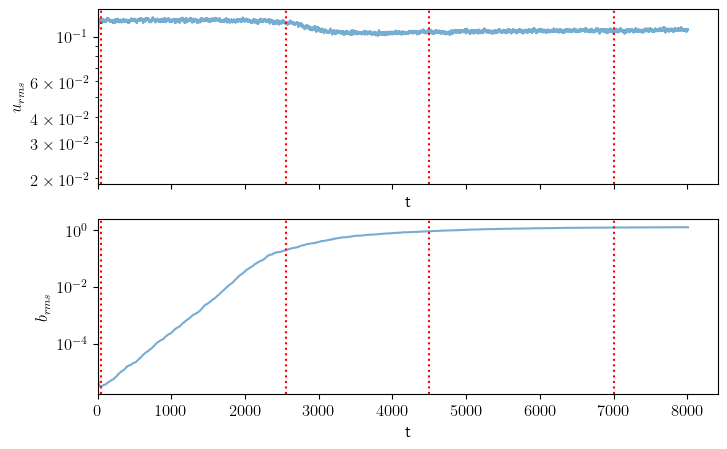

In [10]:
fig, axs = plt.subplots(2,1, sharex=True, figsize=(8,5))
axs[0].plot(ts.t, ts.urms, alpha=0.6)
axs[0].axvline(kinematic.t[kinematic.indx_t1], ls=':', c='r')
axs[0].axvline(kinematic.t[kinematic.indx_t2], ls=':', c='r')
axs[0].axvline(kinematic.t[saturated.indx_t1], ls=':', c='r')
axs[0].axvline(kinematic.t[saturated.indx_t2], ls=':', c='r')
# plt.plot(t_fit, u_fit, '--r')
axs[0].set_yscale('log')
axs[0].set_xlim(0,)
axs[0].set_xlabel("t")
axs[0].set_ylabel(r"$u_{rms}$")

axs[1].semilogy(ts.t, ts.brms, alpha=0.6)
axs[1].axvline(kinematic.t[kinematic.indx_t1], ls=':', c='r')
axs[1].axvline(kinematic.t[kinematic.indx_t2], ls=':', c='r')
axs[1].axvline(kinematic.t[saturated.indx_t1], ls=':', c='r')
axs[1].axvline(kinematic.t[saturated.indx_t2], ls=':', c='r')
axs[1].set_yscale('log')
axs[1].set_xlim(0,)
axs[1].set_xlabel("t")
axs[1].set_ylabel(r"$b_{rms}$")

plt.show()

In [11]:
# saturated.t[-1]

In [12]:
np.shape(kinematic.uz_real)

(6250, 400)

In [13]:
# np.shape(saturated.uz_real)

In [14]:
indx_kin = kinematic.indx_k(2)
indx_sat = saturated.indx_k(2)

In [15]:
kinematic.k_til[indx_kin]

1.9634954084936207

In [16]:
P_kin = kinematic.Power(indx_kin)
P_kin_filt = kinematic.Power_filtered(P_kin,3)
P_sat = saturated.Power(indx_sat)
P_sat_filt = saturated.Power_filtered(P_sat,3)

In [17]:
P_kin_filt =convolve(P_kin, Box1DKernel(5))
P_sat_filt =convolve(P_sat, Box1DKernel(5))

In [18]:
# kinematic.om_til[:kinematic.upto_indx-1]

In [19]:
# fig, axs = plt.subplots(2,1, figsize=(12,5))
# axs[0].plot(ts.t, ts.urms, alpha=0.6)
# # plt.plot(t_fit, u_fit, '--r')
# axs[0].set_yscale('log')
# axs[0].set_xlim(0,)
# axs[0].set_xlabel("t")
# axs[0].set_ylabel(r"$u_{rms}$")

# axs[1].semilogy(ts.t, ts.brms, alpha=0.6)
# axs[1].set_yscale('log')
# axs[1].set_xlim(0,)
# axs[1].set_xlabel("t")
# axs[1].set_ylabel(r"$b_{rms}$")

# plt.show()

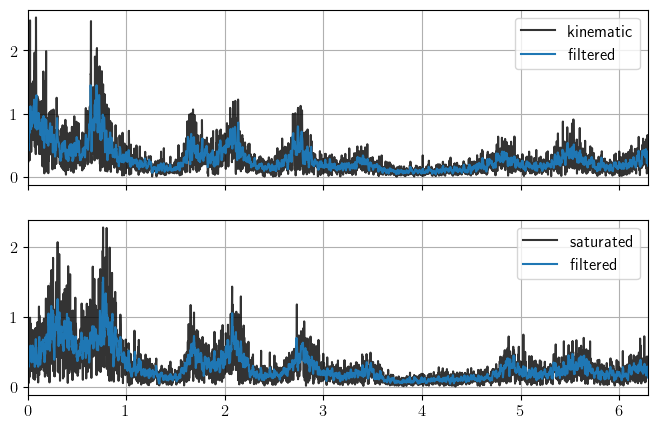

In [20]:
# fig, axs = plt.subplots(2,1, sharex=True, figsize=(8,5))#sharex=True,
fig, axs = plt.subplots(2,1, sharex=True, figsize=(8,5))#sharex=True,

# kinematic.plot(axs[0], P_kin, c='k', alpha=0.4, label='kinematic')

kinematic.plot(axs[0], P_kin, label='kinematic', c='k', alpha=0.8)
kinematic.plot(axs[0], P_kin_filt, label='filtered')
saturated.plot(axs[1], P_sat, label='saturated', c='k', alpha=0.8)
saturated.plot(axs[1], P_sat_filt, label='filtered')

# axs[1].set_xlim(0,kinematic.om_til[kinematic.upto_indx-1])
axs[1].set_xlim(kinematic.xlim(kinematic.om_til[:kinematic.upto_indx-1]))
# axs[1].set_ylim(0,1.75)
axs[0].grid()
axs[1].grid()

In [21]:
num = [0,1,2]
howmany = len(num)

In [22]:
# f_om = kinematic.f_freq(kinematic.k_til[indx_kin])
f_om = kinematic.f_freq(kinematic.k_til[indx_kin], qq=True)
p_om = kinematic.p_freq(kinematic.k_til[indx_kin],num)

In [23]:
f_om

1.267

In [24]:
k_tild_x = kinematic.k_til[indx_kin]
k_tild_x, kinematic.cs_du(k_tild_x)[0]

(1.9634954084936207, 1.963511085228832)

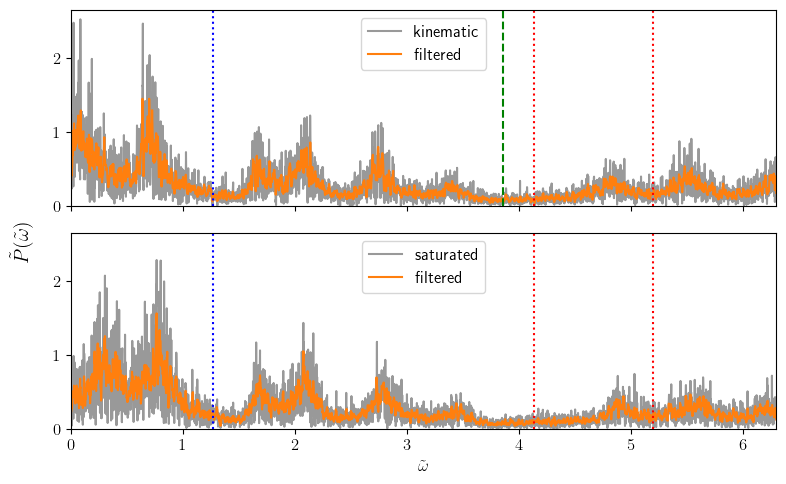

In [25]:
fig, axs = plt.subplots(2,1, sharex=True, sharey=True, figsize=(8,5))#sharex=True,

kinematic.plot(axs[0], P_kin, c='k', alpha=0.4, label='kinematic')
kinematic.plot(axs[0], P_kin_filt, c='C1', label='filtered')
axs[0].axvline(x=f_om, ls=':', c='b')
for i in range(howmany):
    axs[0].axvline(x=p_om[i], ls=':', c='r')
axs[0].axvline(x=kinematic.cs_du(k_tild_x)[0]*k_tild_x, ls='--', c='g')
axs[0].axvline(x=kinematic.cs_du(k_tild_x)[1]*k_tild_x, ls='--', c='g')
# axs[0].grid()
axs[1].set_xlim(kinematic.xlim(kinematic.om_til[:kinematic.upto_indx-1]))
axs[0].set_ylim(0,)
axs[0].legend()

saturated.plot(axs[1], P_sat, c='k', alpha=0.4, label='saturated')
saturated.plot(axs[1], P_sat_filt, c='C1', label='filtered')
axs[1].axvline(x=f_om, ls=':', c='b')
for i in range(howmany):
    axs[1].axvline(x=p_om[i], ls=':', c='r')
# axs[1].axvline(x=mode.cs_u*k_1/(mode.L0*mode.omega0), ls='--', c='g')
# # axs[1].grid()/(mode.L0*mode.omega0)
# axs[1].set_xlim(0, om_tilde_sat[indx_sat-1])
axs[1].set_ylim(0,)
axs[1].legend()

plt.xlabel(r"$\tilde{\omega}$")
fig.supylabel(r"$\tilde{P}(\tilde{\omega})$")
# plt.suptitle(fr"for $\tilde{{k}}_x={k_1}$")
#plt.yscale('log')
plt.tight_layout()
plt.show()

## mode strenthening

### Double fitting

In [26]:
def doublelorentzian(x, a, b, c, d, e, f, h, l):
    y = a/((x-b)**2+np.exp(c))+d+e*x+f/((x-h)**2+np.exp(l))
    return y

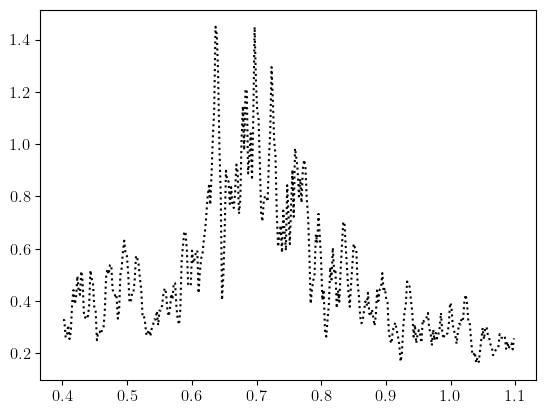

In [31]:
om_kin = kinematic.om_til[:kinematic.upto_indx]
# indx_f = np.argmin(np.abs(om_kin-f_om))
# idl_f_kin = np.argmin(np.abs(om_kin - 0.75))
# idu_f_kin = np.argmin(np.abs(om_kin - 2.10))

idl_f_kin = np.argmin(np.abs(om_kin - 0.4))
idu_f_kin = np.argmin(np.abs(om_kin - 1.10))

# P_f_kin = P_kin[idl_f_kin:idu_f_kin]
P_f_kin = P_kin_filt[idl_f_kin:idu_f_kin]
om_f_kin = om_kin[idl_f_kin:idu_f_kin]
plt.plot(om_f_kin, P_f_kin, c='k', ls=':')

In [28]:
para = kinematic.mode_fit_para(doublelorentzian, om_f_kin, P_f_kin, p0 = np.array([0.6,1.55,-2,-5.7,0.4,0.7,1.1,-2]))

In [29]:
x_kin = np.linspace(para[1]-1.0, para[1]+1.0, 2000)
y_kin = kinematic.mode_fit_extend(doublelorentzian, x_kin, para)

NameError: name 'para_f_kin_lor' is not defined

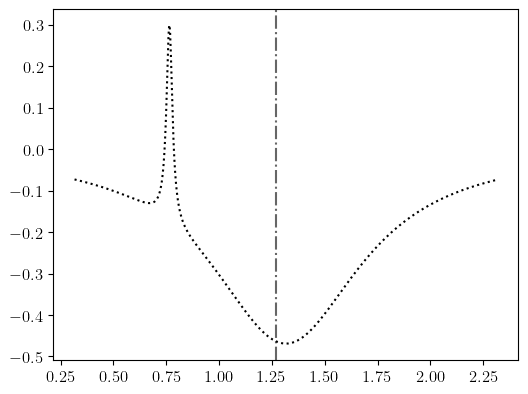

In [30]:
fig, ax = plt.subplots(1,1, sharey=True, figsize=(6,4.55))

## ax.plot(om_f_kin, f_kin, ls=':', color='k', label=r'$kinematic$ $phase$')#fitted_f_kin_lor-para_f_kin_lor[3],
## ax.plot(om_f_sat, f_sat, ls='--', color='k', label=r'$saturated$ $phase$')#fitted_f_sat_lor-para_f_sat_lor[3]
# ax.plot(f_kin[0], f_kin[1], ls=':', color='k', label=r'$kinematic$ $phase$')#fitted_f_kin_lor-para_f_kin_lor[3],
# ax.plot(f_sat[0], f_sat[1], ls='--', color='k', label=r'$saturated$ $phase$')#fitted_f_sat_lor-para_f_sat_lor[3]
ax.plot(x_kin, y_kin, ls=':', color='k', label=r'$kinematic$ $phase$')#fitted_f_kin_lor-para_f_kin_lor[3],
# ax.plot(x_sat, y_sat, ls='--', color='k', label=r'$saturated$ $phase$')#fitted_f_kin_lor-para_f_kin_lor[3],

ax.axvline(x=f_om, ls='-.', c='k', alpha=0.6)
ax.axvline(x=para_f_kin_lor[1], ls='--', c='g')
# ax.axvline(x=om_f_kin[indx_peak], ls='--', c='g')
# ax.axvline(x=para_f_sat_lor[1], ls='--', c='g')


plt.ylim(0,)
plt.legend()
plt.xlabel(r"$\tilde{\omega}$")
plt.ylabel(r"$\tilde{P}(\tilde{\omega})$")
plt.title(r"$f-mode$ $comparision$")
plt.tight_layout()
plt.show()

## end

In [ ]:
om_kin = kinematic.om_til[:kinematic.upto_indx]
# indx_f = np.argmin(np.abs(om_kin-f_om))
idl_f_kin = np.argmin(np.abs(om_kin - 1.12))
idu_f_kin = np.argmin(np.abs(om_kin - 2.10))

# P_f_kin = P_kin[idl_f_kin:idu_f_kin]
P_f_kin = P_kin_filt[idl_f_kin:idu_f_kin]
om_f_kin = om_kin[idl_f_kin:idu_f_kin]

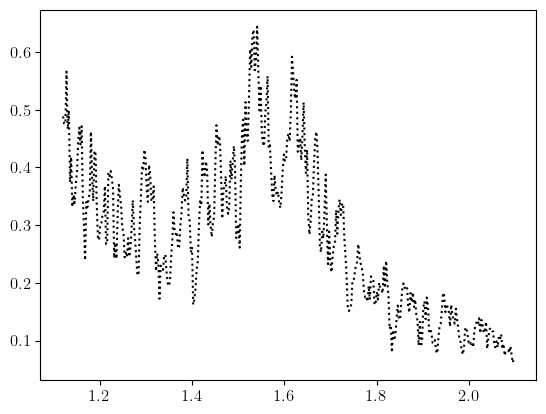

In [ ]:
plt.plot(om_f_kin, P_f_kin, c='k', ls=':')
# plt.plot(om[indx_f-100:indx_f+150], P_kin_filt[indx_f-100:indx_f+150])

In [ ]:
# om_sat = saturated.om_til[:saturated.upto_indx]
# # indx_f = np.argmin(np.abs(om_sat-f_om))
# idl_f_sat = np.argmin(np.abs(om_sat - 0.7))
# idu_f_sat = np.argmin(np.abs(om_sat - 1.25))
# P_f_sat = P_sat[idl_f_sat:idu_f_sat]
# om_f_sat = om_sat[idl_f_sat:idu_f_sat]
# plt.plot(om_f_sat, P_f_sat, c='k', ls=':')

In [ ]:
def lorentzian(x, a, b, c, d, e):
    y = a/((x-b)**2+np.exp(c))+d+e*x
    return y

### ortho

In [ ]:
# para_f_kin_lor, cov_f_kin_lor = curve_fit(lorentzian, om_f_kin, P_kin_filt[indx_f-65:indx_f+100], p0 = np.array([0.6,0.95,-2,-5.7,0.4]))#, sigma=sig_kin_f) #sigma=sig_tot[idl_f_kin:idu_f_kin],
# fitted_f_kin_lor = lorentzian(om_f_kin, *para_f_kin_lor)

# para_f_sat_lor, cov_f_sat_lor = curve_fit(lorentzian, om_f_sat, P_sat_filt[indx_f-60:indx_f+100], p0 = np.array([0.6,0.95,-2,-5.7,0.4]))#, sigma=sig_sat_f) #sigma=sig_tot[idl_f_sat:idu_f_sat],
# fitted_f_sat_lor = lorentzian(om_f_sat, *para_f_sat_lor)

In [ ]:
para_f_kin_lor, cov_f_kin_lor = curve_fit(lorentzian, om_f_kin, P_f_kin, p0 = np.array([0.6,1.55,-2,-5.7,0.4]))#, sigma=sig_kin_f) #sigma=sig_tot[idl_f_kin:idu_f_kin],
fitted_f_kin_lor = lorentzian(om_f_kin, *para_f_kin_lor)

# para_f_sat_lor, cov_f_sat_lor = curve_fit(lorentzian, om_f_sat, P_f_sat, p0 = np.array([0.6,0.95,-2,-5.7,0.4]))#, sigma=sig_sat_f) #sigma=sig_tot[idl_f_sat:idu_f_sat],
# fitted_f_sat_lor = lorentzian(om_f_sat, *para_f_sat_lor)

### None

In [ ]:
# para_f_kin_lor, cov_f_kin_lor = curve_fit(lorentzian, om_f_kin, P_f_kin, p0 = np.array([500,0.93,-2,-7.7,0.4]))#, sigma=sig_kin_f) #sigma=sig_tot[idl_f_kin:idu_f_kin],
# fitted_f_kin_lor = lorentzian(om_f_kin, *para_f_kin_lor)

# para_f_sat_lor, cov_f_sat_lor = curve_fit(lorentzian, om_f_sat, P_f_sat, p0 = np.array([500,0.95,-2,-5.7,0.4]))#, sigma=sig_sat_f) #sigma=sig_tot[idl_f_sat:idu_f_sat],
# fitted_f_sat_lor = lorentzian(om_f_sat, *para_f_sat_lor)

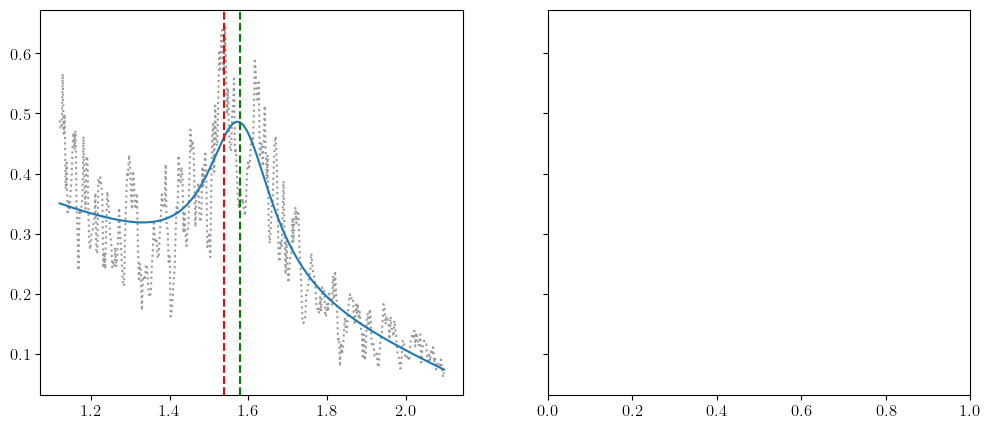

In [ ]:
fig, axes = plt.subplots(1,2, sharey=True, figsize=(12,5))
axes[0].plot(om_f_kin, P_f_kin, c='k', ls=':', alpha=0.4)
# plt.plot(om_f_kin, P_f_kin_wobl, c='k', ls=':')
# plt.plot(om[indx_f-100:indx_f+150], P_kin_filt[indx_f-100:indx_f+150])
axes[0].plot(om_f_kin, fitted_f_kin_lor)
# plt.plot(om_f_kin, bl_f_kin)
axes[0].axvline(x=f_om, ls='--', c='r')
axes[0].axvline(x=para_f_kin_lor[1], ls='--', c='g')

# axes[1].plot(om_f_sat, P_f_sat, c='k', ls=':', alpha=0.4)
# # plt.plot(om_f_kin, P_f_kin_wobl, c='k', ls=':')
# # plt.plot(om[indx_f-100:indx_f+150], P_kin_filt[indx_f-100:indx_f+150])
# axes[1].plot(om_f_sat, fitted_f_sat_lor)
# # plt.plot(om_f_kin, bl_f_kin)
# axes[1].axvline(x=f_om, ls='--', c='r')
# axes[1].axvline(x=para_f_sat_lor[1], ls='--', c='g')

plt.show()

In [ ]:
# fit_f_k = fitted_f_kin_lor-para_f_kin_lor[3]-om_tilde_kin[idl_f_kin:idu_f_kin]*para_f_kin_lor[4]
# fit_f_s = fitted_f_sat_lor-para_f_sat_lor[3]-om_tilde_sat[idl_f_sat:idu_f_sat]*para_f_sat_lor[4]

### ortho

In [ ]:
# f_kin = kinematic.mode_fit(lorentzian, om_f_kin, P_f_kin, p0 = np.array([0.6,0.93,-2,-7.7,0.4]), base=False)#, sigma=sig_kin_f,base=False)
# f_sat = kinematic.mode_fit(lorentzian, om_f_sat, P_f_sat, p0 = np.array([0.6,0.93,-2,-7.7,0.4]), base=False)#, sigma=sig_sat_f,base=False)

In [ ]:
f_kin = kinematic.mode_fit(lorentzian, om_f_kin, P_f_kin, p0 = np.array([0.6,1.55,-2,-7.7,0.4]), base=False)#, sigma=sig_kin_f,base=False)
# f_sat = kinematic.mode_fit(lorentzian, om_f_sat, P_f_sat, p0 = np.array([0.6,0.93,-2,-7.7,0.4]), base=False)#, sigma=sig_sat_f,base=False)

In [ ]:
np.shape(f_kin)

(2, 1000)

### None

In [ ]:
# f_kin = kinematic.mode_fit(lorentzian, om_f_kin, P_f_kin, p0 = np.array([500,0.93,-2,-7.7,0.4]), base=False)#, sigma=sig_kin_f,base=False)
# f_sat = kinematic.mode_fit(lorentzian, om_f_sat, P_f_sat, p0 = np.array([500,0.93,-2,-7.7,0.4]), base=False)#, sigma=sig_sat_f,base=False)

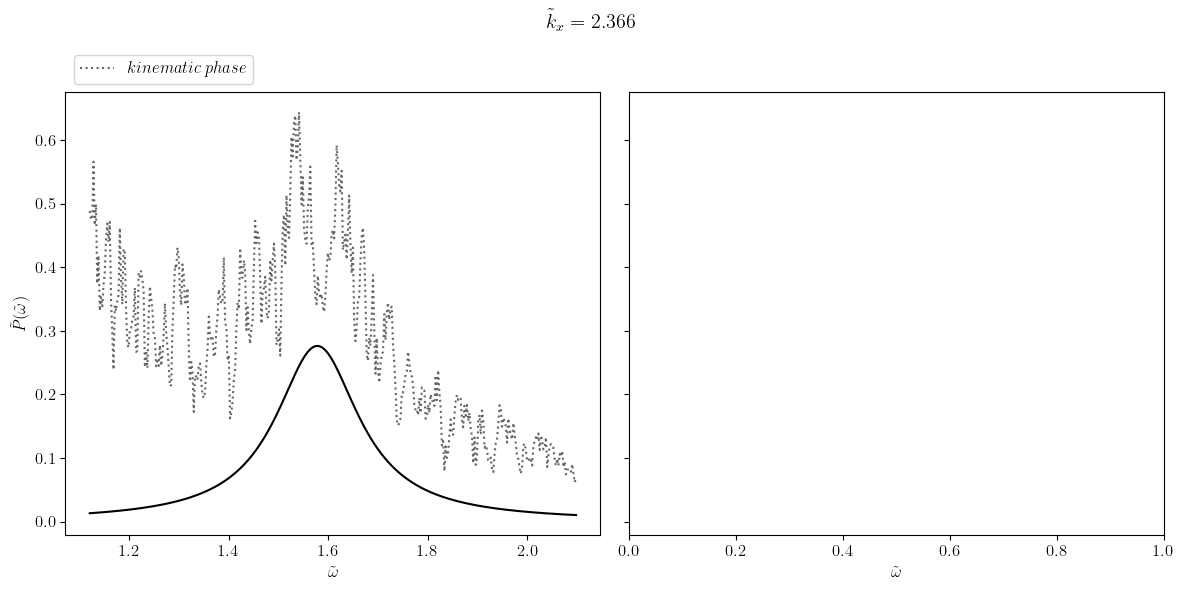

In [ ]:
fig, axes = plt.subplots(1,2, sharey=True, figsize=(12,6))

axes[0].plot(om_f_kin, P_f_kin, color='k', ls=":", alpha=0.6, label=r'$kinematic$ $phase$')
# axes[0].plot(om_f_kin, f_kin, color='k')
axes[0].plot(f_kin[0], f_kin[1], color='k')
axes[0].legend(loc='lower left', bbox_to_anchor=(0.0, 1.0))

# axes[1].plot(om_f_sat, P_f_sat, color='k', ls=":", alpha=0.6, label=r'$saturated$ $phase$')
# # axes[1].plot(om_f_sat, f_sat, color='k')
# axes[1].plot(f_sat[0], f_sat[1], color='k')
# axes[1].legend(loc='lower left', bbox_to_anchor=(0.0, 1.0))

axes[0].set_xlabel(r"$\tilde{\omega}$")
axes[1].set_xlabel(r"$\tilde{\omega}$")
axes[0].set_ylabel(r"$\tilde{P}(\tilde{\omega})$")
plt.suptitle(fr"$\tilde{{k}}_x={round(kinematic.k_til[indx_kin], 3)}$")
plt.tight_layout()
plt.show()

In [ ]:
para_kin = kinematic.mode_fit_para(lorentzian, om_f_kin, P_f_kin, p0 = np.array([0.6,1.53,-2,-7.7,0.4]))
x_kin = np.linspace(para_kin[1]-1.5, para_kin[1]+1.5, 2000)
y_kin = kinematic.mode_fit_extend(lorentzian, x_kin, para_kin)

In [ ]:
# para_sat = saturated.mode_fit_para(lorentzian, om_f_sat, P_f_sat, p0 = np.array([0.6,0.93,-2,-7.7,0.4]))
# x_sat = np.linspace(para_sat[1]-1.0, para_sat[1]+1.0, 1500)
# y_sat = saturated.mode_fit_extend(lorentzian, x_sat, para_sat)

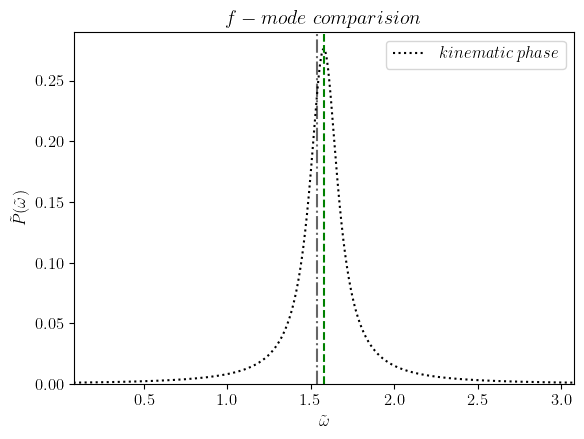

In [ ]:
fig, ax = plt.subplots(1,1, sharey=True, figsize=(6,4.55))

## ax.plot(om_f_kin, f_kin, ls=':', color='k', label=r'$kinematic$ $phase$')#fitted_f_kin_lor-para_f_kin_lor[3],
## ax.plot(om_f_sat, f_sat, ls='--', color='k', label=r'$saturated$ $phase$')#fitted_f_sat_lor-para_f_sat_lor[3]
# ax.plot(f_kin[0], f_kin[1], ls=':', color='k', label=r'$kinematic$ $phase$')#fitted_f_kin_lor-para_f_kin_lor[3],
# ax.plot(f_sat[0], f_sat[1], ls='--', color='k', label=r'$saturated$ $phase$')#fitted_f_sat_lor-para_f_sat_lor[3]
ax.plot(x_kin, y_kin, ls=':', color='k', label=r'$kinematic$ $phase$')#fitted_f_kin_lor-para_f_kin_lor[3],
# ax.plot(x_sat, y_sat, ls='--', color='k', label=r'$saturated$ $phase$')#fitted_f_kin_lor-para_f_kin_lor[3],

ax.axvline(x=f_om, ls='-.', c='k', alpha=0.6)
ax.axvline(x=para_f_kin_lor[1], ls='--', c='g')
# ax.axvline(x=om_f_kin[indx_peak], ls='--', c='g')
# ax.axvline(x=para_f_sat_lor[1], ls='--', c='g')

plt.xlim(x_kin[0], x_kin[-1])
plt.ylim(0,)
plt.legend()
plt.xlabel(r"$\tilde{\omega}$")
plt.ylabel(r"$\tilde{P}(\tilde{\omega})$")
plt.title(r"$f-mode$ $comparision$")
plt.tight_layout()
plt.show()

In [ ]:
def mode_mass(x_data, y_data):
    mass = trap(y_data, x=x_data)
    return round(mass, 4)

In [ ]:
# mode_mass(om_f_kin, f_kin), mode_mass(om_f_sat, f_sat)
# mode_mass(f_kin[0], f_kin[1]), mode_mass(f_sat[0], f_sat[1])
mode_mass(x_kin, y_kin)#, mode_mass(x_sat, y_sat)

0.0847

In [ ]:
kinematic.get_kf()#, saturated.get_kf()

5.16441

## Mode Mass

### var files for kinematic phase

In [ ]:
def ave(*args):
    list = [*args]
    arr = np.array(list)
    return round(np.sum(arr)/len(list),4)

In [ ]:
# var6 = pc.read.var('VAR6')
# var12 = pc.read.var('VAR12')
# var18 = pc.read.var('VAR18')
# u_d_kin = ave(kinematic.u_rms_d(var6), kinematic.u_rms_d(var12), kinematic.u_rms_d(var18))

In [ ]:
# var32 = pc.read.var('VAR32')
# var36 = pc.read.var('VAR36')
# var40 = pc.read.var('VAR40')
# u_d_sat = ave(saturated.u_rms_d(var32), saturated.u_rms_d(var36), saturated.u_rms_d(var40))

In [ ]:
u_d_kin = 0.1246    #NOTE: the value is calculated by above method
# u_d_sat = 0.0988

In [ ]:
u_d_kin/(3*kinematic.kf)#, u_d_sat/(3*kinematic.kf)

0.008042222312584271

0.00804

In [ ]:
def mode_mass(x_data, y_data, u_d, **kwargs):
    # if kinematic == True:
    #     u_d = 0.1244
    # elif saturated == True:
    #     u_d = 0.0988
    # else:
    #     u_d = 1     #NOTE: not normalized
    norm = u_d/(3*kinematic.kf)
    mass = trap(y_data, x=x_data)
    norm_mass = mass/norm
    return round(norm_mass, 4)

In [ ]:
mode_mass_kin = mode_mass(f_kin[0], f_kin[1], u_d_kin)#; mode_mass_sat = mode_mass(f_sat[0], f_sat[1], u_d_sat)

In [ ]:
display(Latex(fr'$\mu_{{f,kin}}$ = {mode_mass_kin}'))
# display(Latex(fr'$\mu_{{f,sat}}$ = {mode_mass_sat}'))

<IPython.core.display.Latex object>

9.5735

## Relative Frequency Shift

In [ ]:
def shift(f_om_calc, f_om):
    return round((f_om_calc**2-f_om**2)/f_om**2, 4)

In [ ]:
# shift_kin = (para_f_kin_lor[1]**2-f_om**2)/f_om**2
# shift_sat = (para_f_sat_lor[1]**2-f_om**2)/f_om**2

In [ ]:
shift_kin = shift(para_f_kin_lor[1], f_om)
# shift_sat = shift(para_f_sat_lor[1], f_om)

In [ ]:
display(Latex(fr'$\delta\omega_{{f,kin}}^2/\omega_f^2$ = {shift_kin}'))
# display(Latex(fr'$\delta\omega_{{f,sat}}^2/\omega_f^2$ = {shift_sat}'))

<IPython.core.display.Latex object>

## Line Width

In [ ]:
def indx_fwhm(P_om, om_f, peak_f):
    """
    P_om: fitted spectrum (i.e., P(\omega)
    of P(\omega) vs \omega )
    om_f: freq range around \omega_f
    peak_f: freq of f mode calculated
    from fitting
    """
    indx_peak = np.argmin(np.abs(om_f-peak_f))
    peak = P_om[indx_peak]
    lh = np.argmin(np.abs(P_om[:indx_peak]-peak/2))
    uh = indx_peak + np.argmin(np.abs(P_om[indx_peak+1:]-peak/2))
    return [lh, uh]

In [ ]:
# indx_fwhm_kin = indx_fwhm(f_kin[1], f_kin[0], para_f_kin_lor[1])
# indx_fwhm_sat = indx_fwhm(f_sat[1], f_sat[0], para_f_sat_lor[1])
indx_fwhm_kin = indx_fwhm(y_kin, x_kin, para_kin[1])
# indx_fwhm_sat = indx_fwhm(y_sat, x_sat, para_f_sat_lor[1])


In [ ]:
indx_peak = np.argmin(np.abs(x_kin-para_kin[1]))
peak = y_kin[indx_peak]
print(peak)
print(y_kin[indx_fwhm_kin])

0.2761509920082188
[0.13904848 0.14110899]


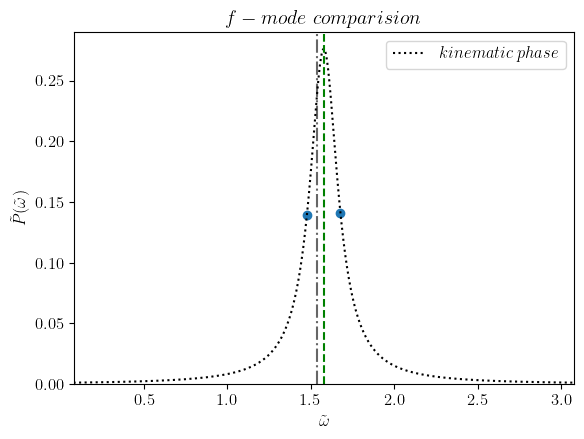

In [ ]:
fig, ax = plt.subplots(1,1, sharey=True, figsize=(6,4.55))
# [indx]
## ax.plot(f_kin[0], f_kin[1], ls=':', color='k', label=r'$kinematic$ $phase$')#fitted_f_kin_lor-para_f_kin_lor[3],
## ax.scatter(f_kin[0][indx_fwhm_kin], f_kin[1][indx_fwhm_kin])

ax.plot(x_kin, y_kin, ls=':', color='k', label=r'$kinematic$ $phase$')#fitted_f_kin_lor-para_f_kin_lor[3],
ax.scatter(x_kin[indx_fwhm_kin], y_kin[indx_fwhm_kin])


## ax.plot(f_sat[0], f_sat[1], ls='--', color='k', label=r'$saturated$ $phase$')#fitted_f_sat_lor-para_f_sat_lor[3]
## ax.scatter(f_sat[0][indx_fwhm_sat], f_sat[1][indx_fwhm_sat])

# ax.plot(x_sat, y_sat, ls='--', color='k', label=r'$saturated$ $phase$')#fitted_f_sat_lor-para_f_sat_lor[3]
# ax.scatter(x_sat[indx_fwhm_sat], y_sat[indx_fwhm_sat])


ax.axvline(x=f_om, ls='-.', c='k', alpha=0.6)
ax.axvline(x=para_f_kin_lor[1], ls='--', c='g')
## ax.axvline(x=om_f_kin[indx_peak], ls='--', c='g')
# ax.axvline(x=para_f_sat_lor[1], ls='--', c='g')

plt.xlim(x_kin[0], x_kin[-1])
plt.ylim(0,)
plt.legend()
plt.xlabel(r"$\tilde{\omega}$")
plt.ylabel(r"$\tilde{P}(\tilde{\omega})$")
plt.title(r"$f-mode$ $comparision$")
plt.tight_layout()
plt.show()

In [ ]:
def line_width(om_f, indx_fwhm:list, f_om):
    return round((om_f[indx_fwhm[1]] - om_f[indx_fwhm[0]])/f_om, 4)

In [ ]:
# ln_wd_kin = line_width(f_kin[0], indx_fwhm_kin, f_om)#; ln_wd_sat =  line_width(f_sat[0], indx_fwhm_sat, f_om)
ln_wd_kin = line_width(x_kin, indx_fwhm_kin, f_om)#; ln_wd_sat =  line_width(x_sat, indx_fwhm_sat, f_om)

In [ ]:
display(Latex(fr'$\Gamma_{{f,kin}}$ = {ln_wd_kin}'))
# display(Latex(fr'$\Gamma_{{f,sat}}$ = {ln_wd_sat}'))

<IPython.core.display.Latex object>

0.1418

## For different $\tilde{k}_x$

In [ ]:
# om_kin = kinematic.om_til[:kinematic.upto_indx]
# # indx_f = np.argmin(np.abs(om_kin-f_om))
# idl_f_kin = np.argmin(np.abs(om_kin - 0.65))
# idu_f_kin = np.argmin(np.abs(om_kin - 1.20))

# P_f_kin = P_kin[idl_f_kin:idu_f_kin]
# om_f_kin = om_kin[idl_f_kin:idu_f_kin]